#Regression Models of the Danceability of Songs on Spotify and an Analysis of Spotify Audio Features





## **Introduction:**

This project uses a machine learning model to predict the “danceability” of a song, using a data set with over 1.2 million songs and a danceability rating for each song. 

The danceability of a song is defined by the data set’s creator as “how suitable a track is for dancing”, and is a value between 0 and 1. Each song within the data set also has other numerical characteristics: energy (0 - 1), loudness in decibels (-60 - 7.23), speechiness (0 - 1), acousticness (0 - 1), instrumentalness (0 -1), tempo in BPM (0 - 249), and valence (0 - 1). To predict the danceability of a song, our model takes each of these numerical values as input and produces a danceability value between 0 and 1 as output. 


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from google.colab import files
import time


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor



from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import matplotlib.pyplot as plt



In [ ]:
# Connecting Google Drive to Colab for easier csv file reading.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Randomly shuffles two arrays so that the indices match.
# After shuffling, the dataset should be random, but data[i] should match with label[i] still.
# We use a random seed of 10 so we can recreate our random set each time.
def shuffle(a, b):
    np.random.seed(10)
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe --> Fitting and transforming data to normalize/scale.

In [ ]:
# Original Dataset, without fit or transform, also without shuffle:
features = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'])
features

,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,0.978,-5.399,0.0727,0.02610,0.000011,0.503,117.906
1,0.957,-5.764,0.1880,0.01290,0.000071,0.489,103.680
2,0.970,-5.424,0.4830,0.02340,0.000002,0.370,149.749
3,0.967,-5.830,0.2370,0.16300,0.000004,0.574,96.752
4,0.929,-6.729,0.0701,0.00162,0.105000,0.539,127.059
...,...,...,...,...,...,...,...
1204020,0.966,-6.970,0.0672,0.00935,0.002240,0.415,159.586
1204021,0.701,-6.602,0.0883,0.10400,0.644000,0.781,121.980
1204022,0.796,-5.960,0.0564,0.03040,0.918000,0.467,121.996
1204023,0.856,-6.788,0.0409,0.00007,0.776000,0.227,124.986


In [ ]:
# Testing shuffling:
values = features.values
labels = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability'])

t, l = shuffle(values, labels.values)

t = pd.DataFrame(t, columns=['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'])

# This should be a shuffled version of the above table. 
t

,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,0.7010,-6.723,0.1570,0.024600,0.544000,0.191,142.523
1,0.8280,-6.714,0.0752,0.000144,0.851000,0.515,107.293
2,0.5780,-6.148,0.0282,0.450000,0.000004,0.725,115.998
3,0.0565,-20.186,0.0353,0.879000,0.000669,0.234,115.030
4,0.5930,-8.465,0.0596,0.299000,0.000002,0.949,125.941
...,...,...,...,...,...,...,...
1204020,0.8210,-9.537,0.1070,0.160000,0.000100,0.632,117.641
1204021,0.1130,-19.088,0.0403,0.954000,0.927000,0.441,121.591
1204022,0.0127,-13.171,0.0563,0.407000,0.959000,0.345,33.685
1204023,0.1330,-25.594,0.0393,0.981000,0.896000,0.500,107.969


In [ ]:
# Testing if shuffle correctly shuffles and keeps indices matched:
shuffled_row = t.values[0]
shuffled_label = l[0]
print("Shuffled row 0: ", shuffled_row)
print("Shuffled label: ", shuffled_label)

for row in range(len(values)):
  if np.array_equal(shuffled_row, values[row]):
    print("Match found in original dataset: ", labels.values[row])


Shuffled row 0:  [ 7.01000e-01 -6.72300e+00  1.57000e-01  2.46000e-02  5.44000e-01
  1.91000e-01  1.42523e+02]
Shuffled label:  [0.436]
Match found in original dataset:  [0.436]


In [ ]:
# Testing feature scaling and normalization:
values = features.values
labels = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability'])

training_size = int(len(values) * 0.1)
testing_size = int(len(values) * 0.075)


# Testing shuffle method, that takes in 3 arrays and shuffles them so the indices match
training, labels = shuffle(values, labels.values)

# Splices the data to be in training and testing based on the sizes above.
training_data = training[0:training_size, :]
training_labels = labels[0:training_size]

testing_data = training[training_size:training_size+testing_size, :]
testing_labels = labels[training_size:training_size+testing_size]

# Scales and fits the data
sc = StandardScaler()
training = sc.fit_transform(training_data)
testing = sc.transform(testing_data)
training = pd.DataFrame(training, columns=['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'])
training_labels = pd.DataFrame(training_labels, columns=['energy'])
testing = pd.DataFrame(testing, columns=['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'])
testing_labels = pd.DataFrame(testing_labels, columns=['energy'])

# Notice that the tempo has become 0.807 instead of in the hundreds range.

# Checks that our split works correctly and with the specified 
print("Training data after shuffling and normalization, ", len(training), " of the original ", len(values))
print("This gives us the train size ratio of ", len(training)/len(values))
training


Training data after shuffling and normalization,  120402  of the original  1204025
This gives us the train size ratio of  0.09999958472623077


,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,0.655391,0.730852,0.625474,-1.099743,0.695775,-0.874612,0.807458
1,1.087169,0.732142,-0.077413,-1.163281,1.512386,0.323722,-0.331918
2,0.237211,0.813251,-0.481272,0.005467,-0.751239,1.100419,-0.050389
3,-1.535801,-1.198421,-0.420263,1.120031,-0.749469,-0.715574,-0.081695
4,0.288209,0.481220,-0.211460,-0.386838,-0.751243,1.928897,0.271178
...,...,...,...,...,...,...,...
120397,-1.566399,-1.624888,-0.170214,1.408414,1.126690,0.227559,-0.980130
120398,-1.528321,-1.333985,-0.388470,0.418557,1.507066,-1.387602,-1.733774
120399,1.610743,0.777425,0.711401,-0.838899,1.235749,0.146191,1.371907
120400,-1.381108,-1.661143,0.805921,1.418806,-0.722787,-0.057230,-1.483810


In [ ]:
# prints out training labels after normalization
print("Training Labels after shuffling (no normalization): ")
training_labels

Training Labels after shuffling (no normalization): 


,energy
0,0.436
1,0.244
2,0.758
3,0.545
4,0.839
...,...
120397,0.391
120398,0.185
120399,0.592
120400,0.390


In [ ]:
# Prints out Testing data after normalization
print("Testing data after shuffling and sizing, ", len(testing), " of the original ", len(values))
print("This gives us the test size ratio of ", len(testing)/len(values))
testing

Testing data after shuffling and sizing,  90301  of the original  1204025
This gives us the test size ratio of  0.07499927327090385


,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,-1.163519,-0.681675,0.247393,0.792676,1.142650,1.130008,-0.461088
1,-0.871134,-0.061321,-0.400500,0.236694,1.209150,-1.424957,-0.003721
2,0.305208,-0.154037,3.254853,-0.980752,-0.750988,-0.293938,-1.318450
3,0.818582,0.326024,0.088427,-0.708996,-0.751086,1.951088,0.361766
4,-0.660344,-1.265630,0.144280,0.709539,1.227769,0.027837,1.447100
...,...,...,...,...,...,...,...
90296,1.393154,0.924740,-0.240675,-1.163574,-0.747099,-0.268048,-0.569043
90297,-0.605947,-0.623064,-0.299965,1.265521,1.722524,-1.420149,-0.067303
90298,-0.044975,0.525501,-0.490724,-0.290710,-0.751216,-0.608315,-1.046526
90299,-0.456354,0.487526,-0.482990,0.990128,-0.751222,0.001947,0.716806


In [ ]:
class Spotify_Dataset(Dataset):
    def __init__(self):
        self.labelsFrame = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability'])
        self.df = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'])

        training_size = int(len(self.df) * 0.1)
        testing_size = int(len(self.df) * 0.075)

        datapoints = self.df.values
        labels = self.labelsFrame.values

        training, labels = shuffle(datapoints, labels)

        training_data = training[0:training_size, :]
        training_labels = labels[0:training_size]

        testing_data = training[training_size:training_size+testing_size, :]
        testing_labels = labels[training_size:training_size+testing_size]


        sc = StandardScaler()
        self.dataset = torch.tensor(sc.fit_transform(training_data), dtype=torch.float32)
        self.labels = torch.tensor(training_labels, dtype=torch.float32)
        self.testing = torch.tensor(sc.transform(testing_data), dtype=torch.float32)
        self.testing_labels = torch.tensor(testing_labels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        try:
          filename = self.dataset[idx]
          label = self.labels[idx]
          return filename, label
        except IOError:
          pass

In [ ]:
dataset = Spotify_Dataset() 

training_data = dataset.dataset
training_labels = dataset.labels
testing_data = dataset.testing
testing_labels = dataset.testing_labels

print("Training Row 0: ", dataset.dataset[0])
print("Training Label Row 0: ", dataset.labels[0])

print("Testing Row 0: ", dataset.testing[0])
print("Testing Label Row 0", dataset.testing_labels[0])


Training Row 0:  tensor([ 0.6554,  0.7309,  0.6255, -1.0997,  0.6958, -0.8746,  0.8075])
Training Label Row 0:  tensor([0.4360])
Testing Row 0:  tensor([-1.1635, -0.6817,  0.2474,  0.7927,  1.1427,  1.1300, -0.4611])
Testing Label Row 0 tensor([0.5550])


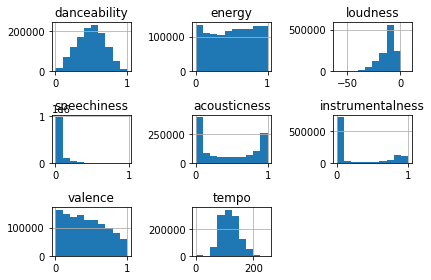

In [ ]:
# Taking a look at the spread of data for each feature we are looking at:
histplot = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability', 'speechiness', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'energy'])
histplot.hist()
plt.tight_layout()

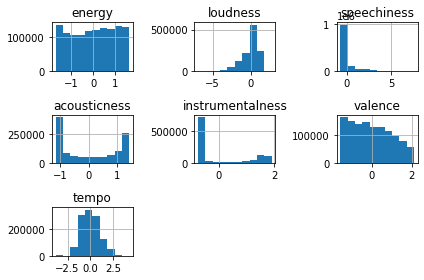

In [ ]:
sc = StandardScaler()
td = dataset.df.values
d = sc.fit_transform(td)

normalized = pd.DataFrame(d, columns=['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'])
normalized.hist()
plt.tight_layout()

As shown in the histograms, most of the data is skewed or does not follow a Gaussian bell curve. This, along with the fact that tempo/loudness cause too much variance in the neural network because of their different scales, is why we chose to normalize and rescale the data.

#Running Polynomial and K-Nearest-Neighbors regression models on the dataset

KNN Scores for K = 1 to 5


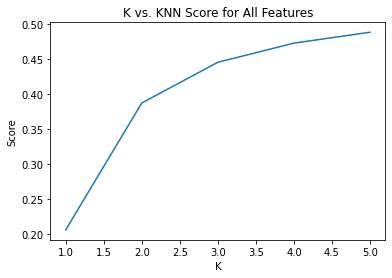

Maximum KNN score =  0.4883731219200218
Elapsed Time KNN:  316.2529766559601


In [ ]:
start_time_knn = time.time()
dataset = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability', 'speechiness', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'energy'])
data = dataset.values


_, data = shuffle(data, data)

# KNN Regression 
# Splitting up the data
X, y = data[:, 1:], data[:, 0]
X = X.astype('float32')
y = y.astype('float32')

# Finds the KNN using k = 1 to 5
k_nearest = []
for i in range(1,6):
 model = KNeighborsRegressor(n_neighbors = i)
 k_nearest.append(np.mean(cross_val_score(model, X, y, cv=5)))

# Plots each value of k that we use
print("KNN Scores for K = 1 to 5")
plt.plot(range(1, 6), k_nearest)
plt.title("K vs. KNN Score for All Features")
plt.xlabel("K")
plt.ylabel("Score")
plt.show()
print("Maximum KNN score = ", np.max(k_nearest))
print("Elapsed Time KNN: ", time.time() - start_time_knn)

In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability', 'speechiness', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'energy'])
data = dataset.values


_, data = shuffle(data, data)

# KNN Regression 
# Splitting up the data
X, y = data[:, 1:], data[:, 0]
X = X.astype('float32')
y = y.astype('float32')
start_time = time.time()
model = KNeighborsRegressor(n_neighbors = 5)
print(np.mean(cross_val_score(model, X, y, cv=5)))
print("TIME: ", time.time() - start_time)

0.4766617186160763
TIME:  55.94323492050171


In [ ]:
# Runs Polynomial regression on all features
# We wanted to see if other models work better than our neural network


dataset = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability', 'speechiness', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'energy'])
data = dataset.values


_, data = shuffle(data, data)

# Polynomial Regression 
# Splices data into data and labels
X, y = data[:, 1:], data[:, 0]
X = X.astype('float32')
y = y.astype('float32')

# Method to easily calculate polynomial regression score based on degree.
# We use random data points, so we use cross validation score. 
def calc_polynomial_regression(deg=2):
  poly_features = PolynomialFeatures(degree=deg)
  X_poly = poly_features.fit_transform(X)
  poly = LinearRegression()
  means = np.mean(cross_val_score(poly, X_poly, y, cv=5))
  return means
start_time = time.time()

print("Polynomial Regression score with degree of 2: ")
print(calc_polynomial_regression(2))

print("Elapsed Time: ", time.time() - start_time)

Polynomial Regression score with degree of 2: 
0.5122117062071707
Elapsed Time:  7.418510437011719


Maximum score for Polynomial Regression:  0.5122117062071707
239.58629822731018


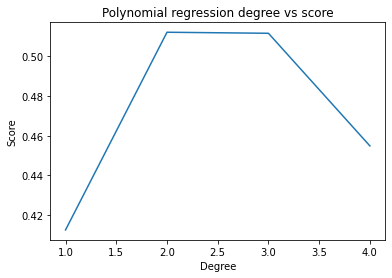

In [ ]:
# Testing on multiple degrees

start = time.time()
pol = []
for i in range(1,5):
  means = calc_polynomial_regression(i)
  pol.append(means)

plt.plot(range(1,5),pol)
plt.title("Polynomial regression degree vs score")
plt.xlabel("Degree")
plt.ylabel("Score")
print("Maximum score for Polynomial Regression: ", np.max(pol))

print(time.time() - start)

### Both the KNN and Polynomial regression models do not give a good score on the full dataset. So now we will look at the correlation of columns using the python .corr() method.

In [ ]:
correlation = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability', 'speechiness', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'energy'])

print("Correlation of data columns printed in the table below: ")
correlation.corr()

Correlation of data columns printed in the table below: 


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
danceability,1.000000,0.283016,0.378194,0.209859,-0.285750,-0.285331,0.563436,0.060590
energy,0.283016,1.000000,0.817934,0.130813,-0.796242,-0.252131,0.399531,0.268231
loudness,0.378194,0.817934,1.000000,0.062403,-0.671553,-0.393037,0.385005,0.246248
speechiness,0.209859,0.130813,0.062403,1.000000,-0.082375,-0.167551,0.099680,0.007745
acousticness,-0.285750,-0.796242,-0.671553,-0.082375,1.000000,0.244132,-0.268836,-0.231021
instrumentalness,-0.285331,-0.252131,-0.393037,-0.167551,0.244132,1.000000,-0.284707,-0.071455
valence,0.563436,0.399531,0.385005,0.099680,-0.268836,-0.284707,1.000000,0.176199
tempo,0.060590,0.268231,0.246248,0.007745,-0.231021,-0.071455,0.176199,1.000000


Note that most features have correlations to other features close to 0. However, Energy is related to loudness at a 0.818 correlation and related to acousticness at a -0.796 correlation. Thus, these three are the most correlated data in the dataset. We will run the same models on all features and then on Energy, Loudness, and Acousticness to prove that this set of features are more correlated than our initial danceability + 7 other features set.

#Now running the same regression models on Energy, Loudness, and Acousticness

KNN Scores for K = 1 to 5


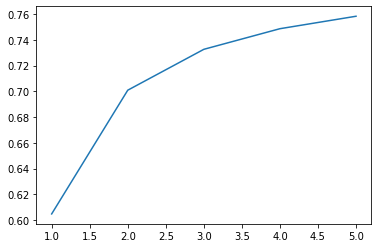

Maximum KNN score =  0.758369966971375


In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['loudness', 'acousticness','energy'])
data = dataset.values


_, data = shuffle(data, data)

# KNN Regression on Energy, using Loudness and Acousticness as the features

X, y = data[:, 1:], data[:, 0]
X = X.astype('float32')
y = y.astype('float32')

# Finds the KNN using k = 1 to 5
k_nearest = []
for i in range(1,6):
 model = KNeighborsRegressor(n_neighbors = i)
 k_nearest.append(np.mean(cross_val_score(model, X, y, cv=5)))

# Plots each value of k that we use
print("KNN Scores for K = 1 to 5")
plt.plot(range(1, 6), k_nearest)
plt.title("K vs. KNN score for Subset Features")
plt.xlabel("K")
plt.ylabel("Score")
plt.show()
print("Maximum KNN score = ", np.max(k_nearest))

Here, we found that the maximum KNN score is much higher for Energy, Loudness, and Acousticness.

In [ ]:
# Runs Polynomial regression on Loudness, Acousticness, and Energy (Energy being the label)
# Since the python .corr() method showed that these three features are highly correlated, we tested to see 
# if the accuracy of this model is higher than if we used all features.

dataset = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['loudness', 'acousticness','energy'])
data = dataset.values


_, data = shuffle(data, data)

# Polynomial Regression on Energy, using Loudness and Acousticness as the features
# Splices data into data and labels
X, y = data[:, 1:], data[:, 0]
X = X.astype('float32')
y = y.astype('float32')

# Method to easily calculate polynomial regression score based on degree.
# We use random data points, so we use cross validation score. 
def calc_polynomial_regression(deg=2):
  poly_features = PolynomialFeatures(degree=deg)
  X_poly = poly_features.fit_transform(X)
  poly = LinearRegression()
  means = np.mean(cross_val_score(poly, X_poly, y, cv=5))
  return means


print("Polynomial Regression score on E, L, A with degree of 2: ")
calc_polynomial_regression(2)

Polynomial Regression score on E, L, A with degree of 2: 


0.8072613528814255

Maximum score for Polynomial Regression:  0.8104593861073675


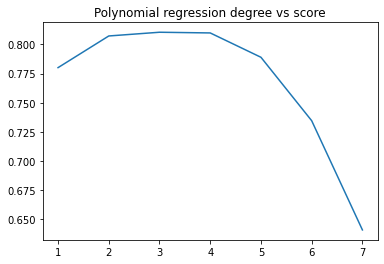

In [ ]:
# Testing on multiple degrees
pol = []
for i in range(1,8):
  means = calc_polynomial_regression(i)
  pol.append(means)

plt.plot(range(1,8),pol)
plt.title("Polynomial Regression Degree vs Score for Subset Features")
plt.xlabel("Degree")
plt.ylabel("Score")
print("Maximum score for Polynomial Regression: ", np.max(pol))

#Trying a Decision Tree on our data:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
start_time_dt = time.time()

dataset = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['danceability', 'speechiness', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'energy'])
data = dataset.values


_, data = shuffle(data, data)

# Splices data into data and labels
X, y = data[:, 1:], data[:, 0]
X = X.astype('float32')
y = y.astype('float32')

dt = DecisionTreeRegressor()
dt_mean = np.mean(cross_val_score(dt, X, y, cv=5))
print("Decision Tree mean: ", dt_mean)

print("Elapsed Time DT: ", time.time() - start_time_dt)


Decision Tree mean:  0.2610628867420728
Elapsed Time DT:  93.13266396522522


##And now on only the Energy, Loudness, and Acousticness features:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
start_time_dt = time.time()

dataset = pd.read_csv("/content/drive/My Drive/tracks_features.csv", usecols=['loudness', 'acousticness', 'energy'])
data = dataset.values


_, data = shuffle(data, data)

# Splices data into data and labels
X, y = data[:, 1:], data[:, 0]
X = X.astype('float32')
y = y.astype('float32')

dt = DecisionTreeRegressor()
dt_mean = np.mean(cross_val_score(dt, X, y, cv=5))
print("Decision Tree mean: ", dt_mean)

print("Elapsed Time DT: ", time.time() - start_time_dt)

Decision Tree mean:  0.630606011648593
Elapsed Time DT:  30.042876482009888


#Neural Network on our features:

In [ ]:
class Spotify_Model(nn.Module):
  def __init__(self, input_size = 7, num_classes = 1):
    super().__init__()

    self.linear1 = nn.Linear(input_size, 6)
    self.linear2 = nn.Linear(5, 6)
    self.linear3 = nn.Linear(6, 4)
    self.linear4 = nn.Linear(4, 2)
    self.linear5 = nn.Linear(2, 6)
    self.linear6 = nn.Linear(2, 5)
    self.linear7 = nn.Linear(5, 3)
    self.linear8 = nn.Linear(3, num_classes)

    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()


  def forward(self, x):
    output = self.linear1(x)
    output = self.sigmoid(output)

    #output = self.linear2(output)
    #output = self.sigmoid(output)
    
    output = self.linear3(output)
    output = self.relu(output)
    
    output = self.linear4(output)
    output = self.relu(output)
    
    #output = self.linear5(output)
    #output = self.sigmoid(output)
    
    output = self.linear6(output)
    output = self.relu(output)
    
    output = self.linear7(output)
    output = self.sigmoid(output)
    
    output = self.linear8(output)
    return output




In [ ]:
def train_model(model, data, labels, num_epochs = 5, error=1e-04):

  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  epoch_number = []
  loss_1000 = []
  accuracy_1000 = []

  for epoch in range(num_epochs):
    print("epoch ", epoch)
    running_loss = 0
    correct = 0
    total = 0
    for i in range(len(data)):
      estimated_outputs = model.forward(data[i][0:7])
      loss = loss_func(estimated_outputs, labels[i])
      optimizer.zero_grad()

      loss.backward()
      optimizer.step()
      last_loss = loss.item()

      running_loss += loss.item()  
      predicted = estimated_outputs
      total += labels.size(0)
      correct += torch.isclose(predicted, labels[i],rtol=1e-01).sum().item()


      if (i % 10000 == 0):
          print("Training... on ", i, " of ", len(data))
          print("Loss: ", loss.item())

    epoch_number.append(epoch)
    train_loss = running_loss/len(data)
    accuracy = 100. * correct/total
   
    accuracy_1000.append(accuracy)
    loss_1000.append(train_loss)
    print("Epoch ", epoch, " finished... Loss: ", train_loss, " Accuracy: ", accuracy)

      
  plt.subplot(1, 2, 1)
  plt.plot(epoch_number, loss_1000)
  plt.ylabel('loss')
  plt.xlabel('epoch number')

  plt.subplot(1, 2, 2)
  plt.plot(epoch_number, accuracy_1000)
  plt.ylabel('accuracy')
  plt.xlabel('epoch number')

  plt.tight_layout()
  plt.show()   



In [ ]:
def isclose(a, b, rel_tol=1e-02, abs_tol=0.0):
    sum = 0
    for i in range(len(a)):
      sum += abs(a[i]-b[i]) <= max(rel_tol * max(abs(a[i]), abs(b[i])), abs_tol)
      if i % 1000 == 0:
              print("Testing... on ", i, " of ", len(a))
    return sum

In [ ]:
a = np.array([5,4,3])
b = np.array([5.005,4.005,4])

print(isclose(a,b))

Testing... on  0  of  3
2


In [ ]:
def test_model(model, data, labels):
    model.eval()
    correct = 0
    with torch.no_grad():
        for i in range(len(data)):
            output = model(data[i])
            # Retrieve the index associated with the highest probability
            pred = output
            #correct += pred.eq(labels.view_as(pred)).sum().item()

            
            correct += torch.isclose(pred, labels[i],rtol=1e-01).sum().item()
            # print(pred.item(), labels[i].item())


            if i % 10000 == 0:
              print("Testing... on ", i, " of ", len(data))

            
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(data),
        100.0 * correct / len(data)))

epoch  0
Training... on  0  of  120402
1.5520981550216675
Training... on  10000  of  120402
0.013730584643781185
Training... on  20000  of  120402
0.006106603424996138
Training... on  30000  of  120402
0.057901620864868164
Training... on  40000  of  120402
0.00013209789176471531
Training... on  50000  of  120402
0.08529061079025269
Training... on  60000  of  120402
0.006571340840309858
Training... on  70000  of  120402
0.033275824040174484
Training... on  80000  of  120402
0.002540825866162777
Training... on  90000  of  120402
0.03503594547510147
Training... on  100000  of  120402
9.743732334754895e-06
Training... on  110000  of  120402
0.004199630115181208
Training... on  120000  of  120402
0.027486203238368034
Epoch  0  finished... Loss:  0.03914110325771181  Accuracy:  0.00015820905714928924
epoch  1
Training... on  0  of  120402
0.002964501269161701
Training... on  10000  of  120402
0.014080571010708809
Training... on  20000  of  120402
0.00610430259257555
Training... on  30000  of

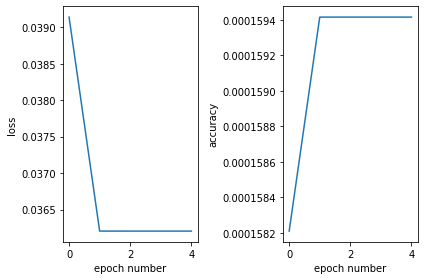

Elapsed Time Neural Net:  927.711311340332


In [ ]:
start_time_neural = time.time()
my_model = Spotify_Model()
# my_model.load_state_dict(state_dict)
train_model(my_model, training_data, training_labels, num_epochs=5)

print("Elapsed Time Neural Net: ", time.time() - start_time_neural)


In [ ]:
test_model(my_model, testing_data, testing_labels)

Testing... on  0  of  90301
Testing... on  10000  of  90301
Testing... on  20000  of  90301
Testing... on  30000  of  90301
Testing... on  40000  of  90301
Testing... on  50000  of  90301
Testing... on  60000  of  90301
Testing... on  70000  of  90301
Testing... on  80000  of  90301
Testing... on  90000  of  90301

Test set: Accuracy: 17153/90301 (19%)

